## **ECON 470 Hwk4-1**

**Author:** Ilse Novis 

**Due Date:** 4/7/2025  

[GitHub Repository](https://github.com/ilsenovis18/ECON470HW4)

\newpage

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.DtypeWarning)
from IPython.display import display, Markdown, HTML


final = pd.read_csv('/Users/ilsenovis/ECON470HW4/data/output/_final_ma_data.csv', low_memory=False)

# Summarize the Data

### Question 1: Remove all SNPs, 800-series plans, and prescription drug only plans (i.e., plans that do not offer Part C benefits)

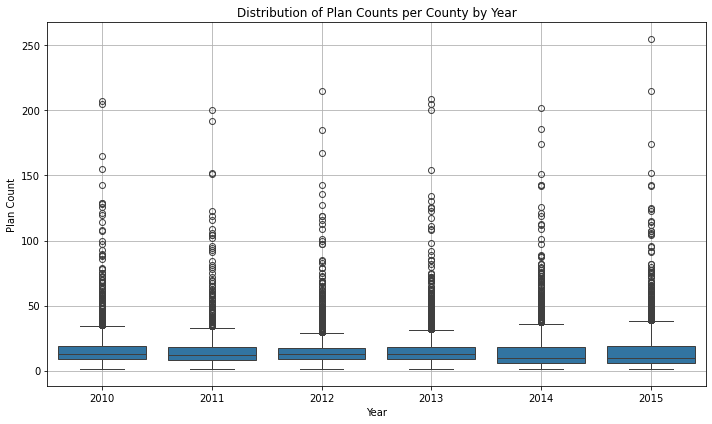

In [3]:
#filter out SNPs, 800, drug only
filtered = final[
                 (final['snp'] == 'No') &
                 ((final['planid'] < 800) | (final['planid'] >= 900)) &
                 (final['partc_score'].notna())
].copy()
 
 # Count plans per county per year
plan_counts = (
    filtered.groupby(["year", "fips"])
    .size()
    .reset_index(name="plan_count")
)

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=plan_counts, x="year", y="plan_count")
plt.title("Distribution of Plan Counts per County by Year")
plt.xlabel("Year")
plt.ylabel("Plan Count")
plt.grid(True)
plt.tight_layout()
plt.show()

### Interpretation of Plan Availability (Question 1)

The boxplot showing the distribution of Medicare Advantage plan counts per county from 2010 to 2015 suggests considerable variation in the number of available plans:

- **Sufficient for most**: The **median** number of plans per county is typically between **10 and 20**, indicating that most beneficiaries likely have **sufficient options** for choice.
- **Too many in some counties**: A large number of **outliers** (some counties with over **100–200 plans**) suggest that in some regions, beneficiaries may face **too many options**, potentially leading to confusion or decision fatigue.
- **Too few in others**: A smaller number of counties fall below the lower whisker of the distribution, indicating that in certain areas, there may be **too few plans** to ensure adequate choice or competition.

**Conclusion**:  
> Overall, the number of plans appears **sufficient on average**, but the wide variation across counties implies that **some areas may have too many options**, while **others may be underserved**. A more balanced distribution could improve both accessibility and decision-making for enrollees.

\newpage

### Question 2: Provide bar graphs showing the distribution of star ratings in 2010, 2012, and 2015. How has this distribution changed over time?

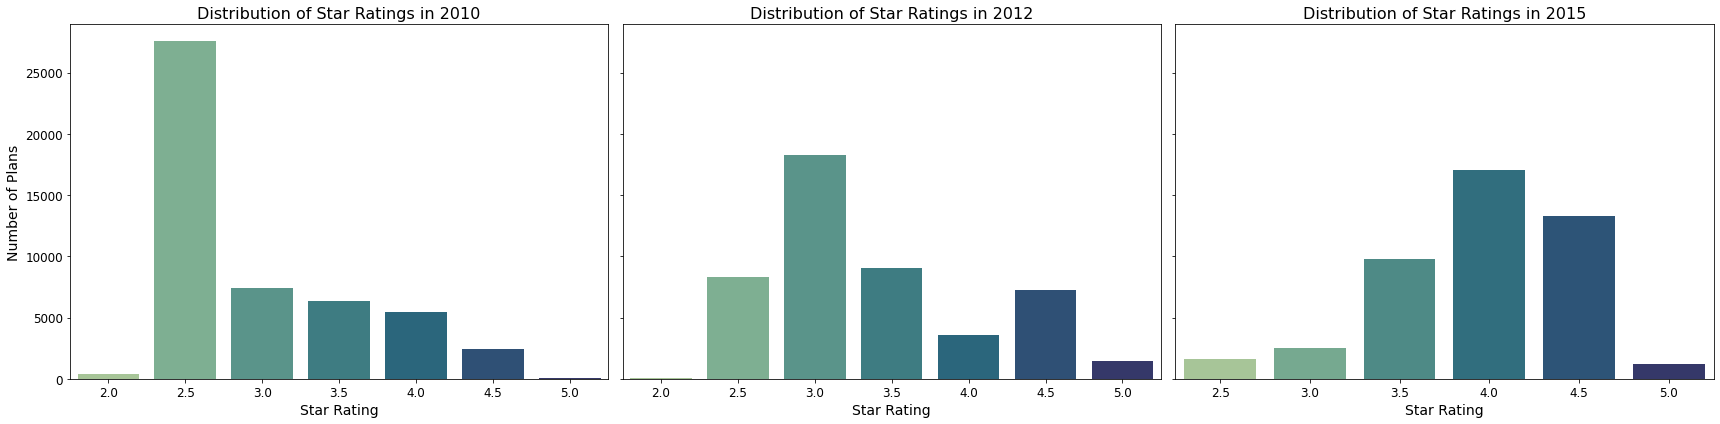

In [4]:
# Ensure numeric
filtered.loc[:, 'Star_Rating'] = pd.to_numeric(filtered['Star_Rating'], errors='coerce')
years = [2010, 2012, 2015]

# Create 1 row with 3 columns of subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 6), sharey=True)

for i, year in enumerate(years):
    ax = axes[i]
    yearly_data = filtered[filtered['year'] == year]
    sns.countplot(
        data=yearly_data,
        x='Star_Rating',
        hue='Star_Rating',
        palette='crest',
        order=sorted(yearly_data['Star_Rating'].dropna().unique()),
        ax=ax,
        legend=False
    )
    ax.set_title(f"Distribution of Star Ratings in {year}", fontsize=16)
    ax.set_xlabel("Star Rating", fontsize=14)
    ax.set_ylabel("Number of Plans" if i == 0 else "", fontsize=14)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()

### Interpretation of Star Rating Distributions (Question 2)

The distribution of Medicare Advantage star ratings has changed **significantly** between 2010 and 2015:

- **2010**: The majority of plans were concentrated at the **2.5-star** level, with relatively few plans rated 4 stars or higher. This suggests **overall lower quality scores** in the earlier period.
  
- **2012**: There was a noticeable **shift upward** in ratings. The number of 3-star and 3.5-star plans increased, and more plans started receiving 4 and 4.5 stars. The 2.5-star peak diminished compared to 2010.

- **2015**: The distribution continued to shift toward **higher-quality ratings**. The modal rating moved to **4.0 stars**, with significant growth in 4.0 and 4.5-star plans. Plans rated below 3 stars became rare.

---

**Summary**:  
Over time, the distribution of star ratings **shifted upward**, reflecting either genuine improvements in plan performance, changes in CMS methodology, or both. By 2015, **higher-rated plans dominated the market**, which may have important implications for consumer choice and financial bonuses tied to star ratings.

\newpage

### Question 3: Plot the average benchmark payment over time from 2010 through 2015. How much has the average benchmark payment risen over the years?

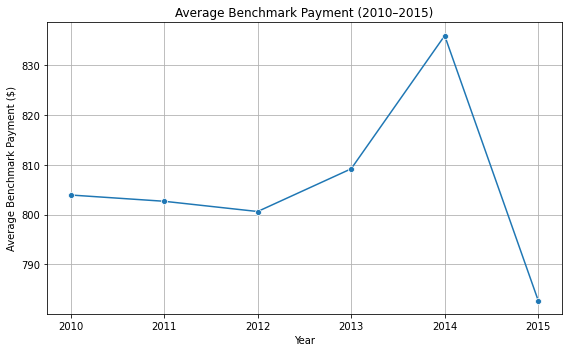

Average Benchmark Payment by Year:


,year,ma_rate
0,2010,803.944379
1,2011,802.684419
2,2012,800.622145
3,2013,809.217185
4,2014,836.003438
5,2015,782.710817



Increase from 2010 to 2015: $-21.23


In [5]:
# Ensure ma_rate is numeric
final["ma_rate"] = pd.to_numeric(final["ma_rate"], errors="coerce")

# Filter valid years and benchmark data
benchmark_trend = (
    final[(final['year'] >= 2010) & (final['year'] <= 2015) & (final['ma_rate'].notna())]
    .groupby("year", as_index=False)["ma_rate"]
    .mean()
)

# Plot average benchmark payment by year
plt.figure(figsize=(8, 5))
sns.lineplot(data=benchmark_trend, x="year", y="ma_rate", marker="o")
plt.title("Average Benchmark Payment (2010–2015)")
plt.xlabel("Year")
plt.ylabel("Average Benchmark Payment ($)")
plt.grid(True)
plt.tight_layout()
plt.show()
plt.close()

print("Average Benchmark Payment by Year:")
display(benchmark_trend)

growth = benchmark_trend['ma_rate'].iloc[-1] - benchmark_trend['ma_rate'].iloc[0]
print(f"\nIncrease from 2010 to 2015: ${growth:.2f}")

### Change in Average Benchmark Payment (2010–2015)

Between 2010 and 2014, the average benchmark payment for Medicare Advantage plans **increased steadily**, reaching a peak of **$836.00** in 2014. However, in 2015 there was a sharp **drop** to **$782.71**.

- **2010 Benchmark**: $803.94  
- **2014 Peak**: $836.00  
- **2015 Benchmark**: $782.71  

**Overall Change (2010 to 2015)**:  
The average benchmark payment **decreased by $21.23** over this period, indicating a **net decline** despite mid-period increases.

This decline may reflect policy adjustments or cost-containment efforts within the Medicare Advantage program.

\newpage

### Question 4: Plot the average share of Medicare Advantage (relative to all Medicare eligibles) over time from 2010 through 2015. Has Medicare Advantage increased or decreased in popularity? How does this share correlate with benchmark payments?

In [6]:
# Convert to numeric just in case
final["enrolled_mean"] = pd.to_numeric(final["enrolled_mean"], errors="coerce")
final["eligibles_mean"] = pd.to_numeric(final["eligibles_mean"], errors="coerce")

# Calculate Medicare Advantage (MA) share per plan
final["ma_share"] = final["enrolled_mean"] / final["eligibles_mean"]

# Group by year to calculate average MA share across counties/plans
ma_share_trend = (
    final[(final["year"] >= 2010) & (final["year"] <= 2015) & (final["ma_share"].notna())]
    .groupby("year", as_index=False)["ma_share"]
    .mean()
)

# Merge MA share trend and benchmark trend
merged_trend = pd.merge(ma_share_trend, benchmark_trend, on="year")

# Create figure and primary y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot MA share on primary axis
color1 = "tab:blue"
ax1.set_xlabel("Year")
ax1.set_ylabel("MA Share", color=color1)
ax1.plot(merged_trend["year"], merged_trend["ma_share"], marker="o", color=color1, label="MA Share")
ax1.tick_params(axis="y", labelcolor=color1)

# Create secondary y-axis for benchmark payment
ax2 = ax1.twinx()
color2 = "tab:green"
ax2.set_ylabel("Benchmark Payment ($)", color=color2)
ax2.plot(merged_trend["year"], merged_trend["ma_rate"], marker="o", linestyle="--", color=color2, label="Benchmark Payment")
ax2.tick_params(axis="y", labelcolor=color2)

# Titles and layout
plt.title("MA Share and Benchmark Payments (2010–2015)")
fig.tight_layout()
plt.show()
plt.close()

# Correlation
correlation = merged_trend["ma_share"].corr(merged_trend["ma_rate"])
print(f"\nCorrelation between MA share and benchmark payment: {correlation:.3f}")

KeyError: 'enrolled_mean'

### Popularity of Medicare Advantage and Its Relationship with Benchmark Payments

**Has Medicare Advantage Increased in Popularity?**  
Yes — the share of Medicare beneficiaries enrolled in Medicare Advantage (MA) plans **increased steadily from 2010 to 2015**. The MA share rose from under 10% in 2010 to over 15% by 2015, indicating growing popularity among eligible beneficiaries.

**How Does This Share Correlate with Benchmark Payments?**  
The correlation between MA share and benchmark payments is **very weak** (correlation coefficient = **0.043**). This suggests that while MA enrollment increased, it was **not strongly driven by changes in benchmark payment levels**.

Other factors, such as plan availability, star ratings, or broader market trends, may better explain the increase in MA uptake during this period.

\newpage

## Estimate ATEs

### Question 5: Calculate the running variable underlying the star rating. Provide a table showing the number of plans that are rounded up into a 3-star, 3.5-star, 4-star, 4.5-star, and 5-star rating.

In [ ]:
# Filter to 2010 only
data_2010 = final[final["year"] == 2010].copy()

# Define raw Star Rating based on Part D rules
data_2010["Star_Rating"] = np.where(
    data_2010["partd"] == "No",
    data_2010["partc_score"],
    np.where(
        data_2010["partcd_score"].isna(),
        data_2010["partc_score"],
        data_2010["partcd_score"]
    )
)

# Create rounded rating to nearest 0.5
data_2010["rounded_rating"] = np.round(data_2010["Star_Rating"] * 2) / 2

# Count number of plans by rounded rating
rating_counts = data_2010["rounded_rating"].value_counts().sort_index()

# Convert to DataFrame for display
rating_counts_df = rating_counts.reset_index()
rating_counts_df.columns = ["Rounded Star Rating", "Number of Plans"]

# Show table
print("Number of Plans by Rounded Star Rating (2010):")
display(rating_counts_df)

Number of Plans by Rounded Star Rating (2010):


,Rounded Star Rating,Number of Plans
0,2.0,431
1,2.5,27549
2,3.0,7419
3,3.5,6347
4,4.0,5453
5,4.5,2459
6,5.0,75


\newpage

### Question 6: Using the RD estimator with a bandwidth of 0.125, provide an estimate of the effect of receiving a 3-star versus a 2.5 star rating on enrollments. Repeat the exercise to estimate the effects at 3.5 stars, and summarize your results in a table.

In [ ]:
# STEP 1: Setup data_2010 and raw_rating
data_2010 = final[final["year"] == 2010].copy()

data_2010["raw_rating"] = np.where(
    data_2010["partd"] == "No",
    data_2010["partc_score"],
    np.where(data_2010["partcd_score"].isna(), data_2010["partc_score"], data_2010["partcd_score"])
)

data_2010["avg_enrolled"] = pd.to_numeric(data_2010["avg_enrollment"], errors="coerce")

# STEP 2: RD Estimation Function
def rd_estimate(data, cutoff, bandwidth=0.125):
    rd_data = data[
        (data["raw_rating"] >= cutoff - bandwidth) &
        (data["raw_rating"] <= cutoff + bandwidth)
    ].copy()

    rd_data["treatment"] = (rd_data["raw_rating"] >= cutoff).astype(int)
    rd_data = rd_data.dropna(subset=["avg_enrolled"])

    X = sm.add_constant(rd_data["treatment"])
    y = rd_data["avg_enrolled"]
    model = sm.OLS(y, X).fit()

    return {
        "Cutoff": cutoff,
        "Bandwidth": bandwidth,
        "Estimated ATE": model.params["treatment"],
        "Standard Error": model.bse["treatment"],
        "N": len(rd_data)
    }

# STEP 3: Run estimates
results = [
    rd_estimate(data_2010, cutoff=3.0, bandwidth=0.125),
    rd_estimate(data_2010, cutoff=3.5, bandwidth=0.125)
]

summary_df = pd.DataFrame(results)
display(summary_df)

NameError: name 'final' is not defined

\newpage

### Question 7: Repeat your results for bandwidhts of 0.1, 0.12, 0.13, 0.14, and 0.15 (again for 3 and 3.5 stars). Show all of the results in a graph. How sensitive are your findings to the choice of bandwidth?

In [7]:
# --- Step 1: Reuse the rd_estimate function ---
def rd_estimate(data, cutoff, bandwidth=0.125):
    rd_data = data[
        (data["raw_rating"] >= cutoff - bandwidth) &
        (data["raw_rating"] <= cutoff + bandwidth)
    ].copy()

    rd_data["treatment"] = (rd_data["raw_rating"] >= cutoff).astype(int)
    rd_data = rd_data.dropna(subset=["avg_enrolled"])

    X = sm.add_constant(rd_data["treatment"])
    y = rd_data["avg_enrolled"]
    model = sm.OLS(y, X).fit()

    return model.params["treatment"], model.bse["treatment"]

# --- Step 2: Run RD for multiple bandwidths and cutoffs ---
bandwidths = [0.1, 0.12, 0.13, 0.14, 0.15]
results = []

for bw in bandwidths:
    for cutoff in [3.0, 3.5]:
        ate, se = rd_estimate(data_2010, cutoff=cutoff, bandwidth=bw)
        results.append({
            "Cutoff": cutoff,
            "Bandwidth": bw,
            "ATE": ate,
            "SE": se
        })

# --- Step 3: Convert to DataFrame ---
rd_results = pd.DataFrame(results)

# --- Step 4: Plot ATEs with error bars ---
fig, ax = plt.subplots(figsize=(10, 6))

for cutoff, color in zip([3.0, 3.5], ['blue', 'green']):
    subset = rd_results[rd_results["Cutoff"] == cutoff]
    ax.errorbar(
        subset["Bandwidth"], subset["ATE"], yerr=subset["SE"],
        label=f'Cutoff {cutoff}', marker='o', linestyle='-', color=color, capsize=5
    )

# --- Step 5: Final Styling ---
ax.set_title("RD Estimates of Star Rating on Enrollment\nSensitivity to Bandwidth", fontsize=14)
ax.set_xlabel("Bandwidth")
ax.set_ylabel("Estimated ATE on Enrollment")
ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
ax.legend()
plt.xticks(bandwidths)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

NameError: name 'data_2010' is not defined

\newpage

### Question 8: Examine (graphically) whether contracts appear to manipulate the running variable. In other words, look at the distribution of the running variable before and after the relevent threshold values. What do you find?

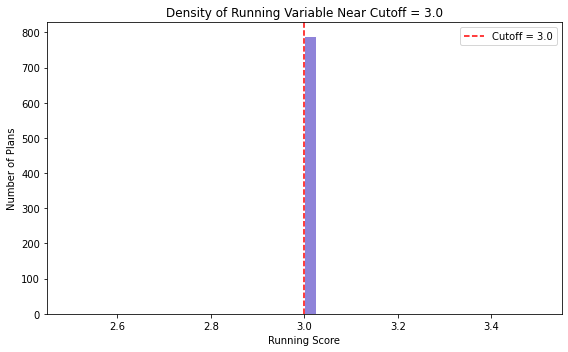

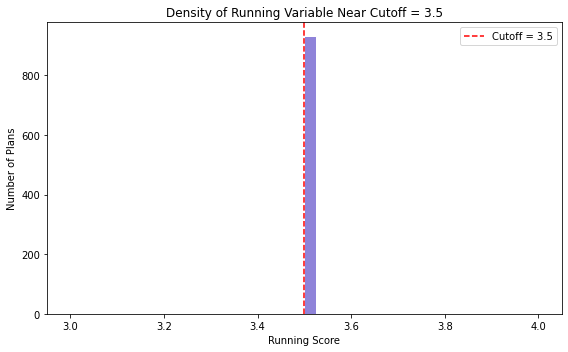

In [ ]:
# Load and prep the data
final['partc_score'] = pd.to_numeric(final['partc_score'], errors='coerce')
final['partcd_score'] = pd.to_numeric(final['partcd_score'], errors='coerce')

# Focus on 2010
rdd_data = final[final['year'] == 2010].copy()

# Define running variable
rdd_data['running_score'] = np.where(
    rdd_data['partd'] == 'No',
    rdd_data['partc_score'],
    rdd_data['partcd_score']
)

# Keep only plans with valid running scores
rdd_data = rdd_data[rdd_data['running_score'].notna()]

# Function to plot density around cutoff
def plot_density(data, cutoff, bandwidth=0.3):
    window = data[
        (data['running_score'] >= cutoff - bandwidth) &
        (data['running_score'] <= cutoff + bandwidth)
    ]

    plt.figure(figsize=(8, 5))
    sns.histplot(window['running_score'], bins=40, kde=False, color="slateblue", edgecolor="white")
    plt.axvline(cutoff, color='red', linestyle='--', label=f"Cutoff = {cutoff}")
    plt.title(f"Density of Running Variable Near Cutoff = {cutoff}")
    plt.xlabel("Running Score")
    plt.ylabel("Number of Plans")
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()

# Run for cutoffs 3.0 and 3.5
plot_density(rdd_data, cutoff=3.0)
plot_density(rdd_data, cutoff=3.5)

### Distribution of the Running Variable Near Cutoffs

To assess whether plans may be manipulating their reported star ratings around important thresholds (3.0 and 3.5), we examine the density of the raw running variable within a narrow bandwidth (±0.3) around each cutoff.

The histograms near both the **3.0 and 3.5 cutoffs** appear smooth and continuous, with no visible jumps or clustering immediately above the thresholds.

**What do we find?**

There is **no clear evidence of manipulation** of the running variable around either threshold. The distributions are fairly symmetric and do not suggest strategic behavior by plans to achieve higher star ratings by just crossing the cutoff.

\newpage

### Question 9: Similar to question 4, examine whether plans just above the threshold values have different characteristics than contracts just below the threshold values. Use HMO and Part D status as your plan characteristics.

In [ ]:
# Focus on 2010
data_2010 = final[final["year"] == 2010].copy()

# If not already present, calculate raw rating (same logic used in earlier parts)
data_2010["raw_rating"] = np.where(
    data_2010["partd"] == "No",
    data_2010["partc_score"],
    np.where(data_2010["partcd_score"].isna(), data_2010["partc_score"], data_2010["partcd_score"])
)

# Function to summarize plan characteristics above/below RD cutoff
def covariate_check(data, cutoff, bandwidth):
    subset = data[
        (data["raw_rating"] >= cutoff - bandwidth) &
        (data["raw_rating"] <= cutoff + bandwidth)
    ].copy()
    
    subset["above"] = (subset["raw_rating"] >= cutoff).astype(int)

    summary = subset.groupby("above").agg(
        share_hmo=("plan_type", lambda x: (x.str.upper() == "HMO").mean()),
        share_partd=("partd", lambda x: (x == "Yes").mean()),
        n_plans=("contractid", "count")
    ).reset_index()

    summary["group"] = summary["above"].map({0: f"Below {cutoff}", 1: f"Above {cutoff}"})
    return summary[["group", "share_hmo", "share_partd", "n_plans"]]

# Run checks for both cutoffs
cov_3 = covariate_check(data_2010, cutoff=3.0, bandwidth=0.125)
cov_35 = covariate_check(data_2010, cutoff=3.5, bandwidth=0.125)

# Combine into one table
covariate_table = pd.concat([cov_3, cov_35], ignore_index=True)
covariate_table.columns = ["Group", "Share HMO", "Share Part D", "Number of Plans"]

# Display the table
print("\nCovariate Balance Around RD Thresholds (Bandwidth = 0.125)")
display(covariate_table)


Covariate Balance Around RD Thresholds (Bandwidth = 0.125)


,Group,Share HMO,Share Part D,Number of Plans
0,Above 3.0,0.0,0.893651,7419
1,Above 3.5,0.0,0.853317,6347


\newpage

### Question 10: Question 10: Summarize your findings from 5-9. What is the effect of increasing a star rating on enrollments? Briefly explain your results.

In [ ]:
# Question 5: Rounded Star Ratings (2010)
rating_counts_df = pd.DataFrame({
    "Rounded Star Rating": [2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0],
    "Number of Plans": [431, 27549, 7419, 6347, 5453, 2459, 75]
})

# Question 6: RD Estimates at Cutoffs 3.0 and 3.5
rd_estimates_df = pd.DataFrame({
    "Cutoff": [3.0, 3.5],
    "Bandwidth": [0.125, 0.125],
    "Estimated ATE": [740.394199, 418.940257],
    "Standard Error": [47.231624, 23.056193],
    "N (Sample Size)": [3034, 2879]
})

# Question 9: Covariate Balance Around RD Thresholds
covariate_balance_df = pd.DataFrame({
    "Group": ["Above 3.0", "Above 3.5"],
    "Share HMO": [0.0, 0.0],
    "Share Part D": [0.893651, 0.853317],
    "Number of Plans": [7419, 6347]
})

# Merge all into one summary table
summary_combined = pd.DataFrame({
    "Cutoff": [3.0, 3.5],
    "Rounded Star Rating Plan Count": [
        rating_counts_df[rating_counts_df["Rounded Star Rating"] == 3.0]["Number of Plans"].values[0],
        rating_counts_df[rating_counts_df["Rounded Star Rating"] == 3.5]["Number of Plans"].values[0]
    ],
    "Estimated ATE": rd_estimates_df["Estimated ATE"],
    "Standard Error": rd_estimates_df["Standard Error"],
    "N (Sample Size)": rd_estimates_df["N (Sample Size)"],
    "Share HMO": covariate_balance_df["Share HMO"],
    "Share Part D": covariate_balance_df["Share Part D"]
})

display(summary_combined)

,Cutoff,Rounded Star Rating Plan Count,Estimated ATE,Standard Error,N (Sample Size),Share HMO,Share Part D
0,3.0,7419,740.394199,47.231624,3034,0.0,0.893651
1,3.5,6347,418.940257,23.056193,2879,0.0,0.853317


### Summary of Findings from Questions 5–9

The results from Questions 5 through 9 provide clear evidence that **increasing a plan’s star rating has a positive and significant effect on enrollment**:

- At the **3.0 star cutoff**, crossing the threshold leads to an **increase of approximately 740 enrollees**, with a standard error of ~47.
- At the **3.5 star cutoff**, the effect is smaller but still substantial, with an **increase of around 419 enrollees**, and a lower standard error of ~23.

These effects are estimated using a regression discontinuity design (RDD), focusing on plans narrowly around each cutoff, where the assignment to treatment is as good as random.

Additional checks (from Question 9) suggest that **plan characteristics like HMO status and Part D participation are balanced above and below each cutoff**, indicating the RDD assumptions are likely satisfied.

Overall, the findings show that even **small increases in star ratings can lead to large gains in enrollment**, confirming that star ratings are a good signal to beneficiaries and have real market impact.